# Homework 5 - Explore Wikipedia's hyperlinks network

Useful libraries

In [1]:
import pandas as pd
import numpy as np
import re
import random
from random import randint
from random import seed
import matplotlib.pyplot as plt

Import the dataset

In [2]:
dataset = pd.read_csv('wikigraph_reduced.csv', sep='\t', 
                      delimiter=None, header='infer',
                      names=None, index_col=None, 
                      usecols=None, 
                      encoding = "ISO-8859-1")

In [4]:
dataset.head()

,Unnamed: 0,0,1
0,796,95,1185516
1,909,108,1059989
2,910,108,1062426
3,911,108,1161925
4,1141,134,541222


In [3]:
dataset.columns

Index(['Unnamed: 0', '0', '1'], dtype='object')

Change the columns name; 0 is the **source** and 1 is the **target**

In [3]:
dataset.columns=['Index','Source','Target']

Make the first column the index

In [4]:
dataset.set_index('Index' , inplace = True)

In [9]:
dataset.head()

,Source,Target
Index,,
796,95,1185516
909,108,1059989
910,108,1062426
911,108,1161925
1141,134,541222


### RQ1. Create the graph
Create two dictionaries for the nodes of the graph; one is for the indegree node, the other one is for the outdegree node. Note that the dictionaries contain the unique element.

In [5]:
in_degree = {v: [] for v in set(dataset.Source)}
out_degree = {v: [] for v in set(dataset.Target)}

In [6]:
for row in dataset.iterrows():
    source = row[1][0]
    target = row[1][1]
    in_degree[source].append(target)
    out_degree[target].append(source)

Visualize how many *in link* and *out link* has the graph

In [9]:
n_art_outlink = len(out_degree)
print(n_art_outlink)

75467


In [10]:
n_art_inlink = len(in_degree)
print(n_art_inlink)

90920


#### Is the graph directed?

In [12]:
if (len(set(dataset.Source).intersection(set(dataset.Target)))!=0):
     print ('The graph is directed')

The graph is directed


#### How many articles are we considering?

In [7]:
#In the variable below we save all the articles that compose the graph
nodes = set(dataset.Source).union(set(dataset.Target))
n_nodes = len(nodes)
print(n_nodes)

98343


#### How many hyperlinks between pages exist?

In [8]:
n_edges = len(dataset)
print(n_edges)

483094


#### Compute the average number of links in an arbitrary page

In [16]:
n_outlinks = []
for node in nodes:
    try:
        out_deg = len(out_degree[node])
    except:
        out_deg = 0
    n_outlinks.append(out_deg)
avg_outlink = np.mean(n_outlinks)
print('The average number of outlinks in a page is: ',round(avg_outlink))

The average number of outlinks in a page is:  5


#### What is the graph density?
For directed graph the density is given by: $$\frac{|E|}{|V|(|V|-1)}$$



In [17]:
density = (n_edges/(n_nodes*(n_nodes-1)))
print(density)

4.9951571365597335e-05


#### The graph is dense or sparse?

Since the value of the density of our graph is very low, we can assume that our graph is **sparse**.

In [18]:
print('Max number of edges:',n_nodes**2)
print('Number of edges: ',n_edges)

Max number of edges: 9671345649
Number of edges:  483094


#### Visualize the nodes' degree distribution

At first we save the connections of each node into a list, then we store that list into a pandas Series in order to plot it.

In [18]:
connections = []
for node in nodes:
    try:
        in_deg = len(in_degree[node])
    except:
        in_deg = 0
    try:
        out_deg = len(out_degree[node])
    except:
        out_deg = 0
    connections.append(in_deg+out_deg)

In [19]:
series=pd.Series(connections)
degrees=series.groupby(by=connections).count()
d_sum=np.sum(degrees)
# the first 50 degrees values are enough to give a true representation
degrees=degrees[0:50]   
degrees=degrees/d_sum

degrees_sum=0
cdf_list=[]
for x in degrees:  
    degrees_sum=(degrees_sum+x)   
    cdf_list.append(degrees_sum)

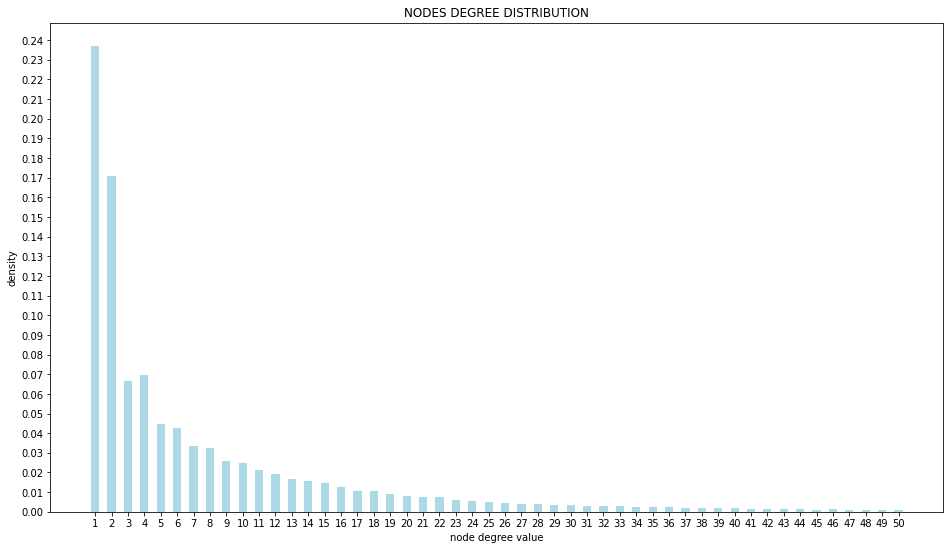

In [20]:
plt.figure(figsize=(16,9));
plt.xticks(np.arange(1,51,1));
plt.yticks(np.arange(0,1,0.01));
plt.xlabel('node degree value');
plt.ylabel('density');
plt.title('nodes degree distribution'.upper());
plt.bar(degrees.index,degrees,color='lightblue',width=0.5);

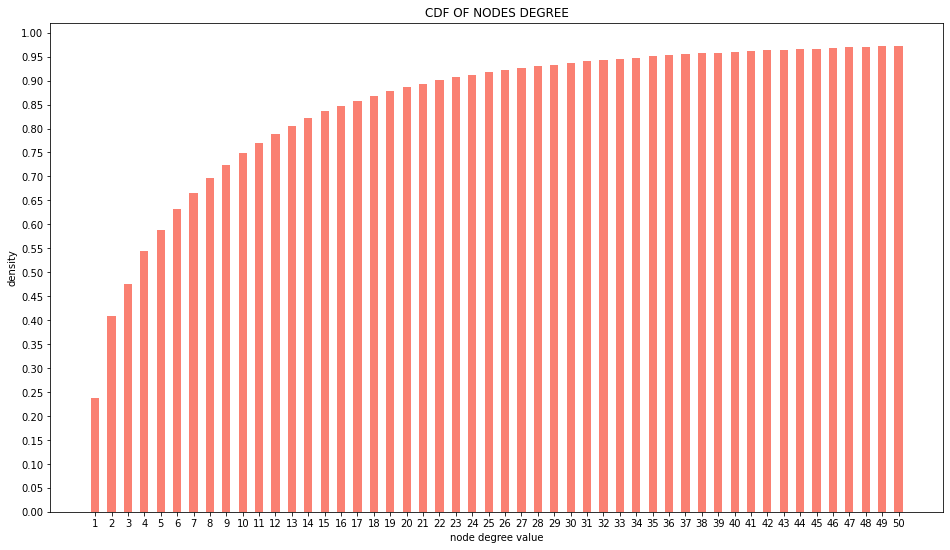

In [21]:
plt.figure(figsize=(16,9));
plt.xticks(np.arange(1,51,1));
plt.yticks(np.arange(0,1.05,0.05));
plt.xlabel('node degree value');
plt.ylabel('density');
plt.title('CDF of nodes degree'.upper());
plt.bar(degrees.index,cdf_list,color='salmon',width=0.5);

#### Importing file of page's names

In [9]:
f_pages=open('wiki-topcats-page-names.txt','r')
names=list(f_pages.readlines())

In [10]:
def text_fix(names):
    for i in range(len(names)):
        names[i]=re.sub('\n','',names[i])
        names[i]=re.sub(f'^{str(i)}','',names[i]).lstrip()
    return names

In [11]:
page_names=text_fix(names)

#### Importing file of categories 

In [9]:
f_cat=open('wiki-topcats-categories.txt','r')
cat=list(f_cat.readlines())
l=cat[0].split(' ')

Once we have the imported file, from this we create 2 dictionaries:
* **categories** is a dictionary with key = node; value = category
* **categories_file** is the same dictionary but with the inverted arguments, like the file's structure: key= category; value = nodes

In [10]:
categories={v: [] for v in nodes} 
categories_file = {} 

for i in range(len(cat)):
    support_list=cat[i].split(' ')  
    support_list[-1]=support_list[-1][0:-2]  
    category=support_list[0][9:-1]
    cat_nodes = []
    for node in support_list[1:]:
        try:
            categories[int(node)].append(category)
        except:
            0
        try:
            node = int(node)
            if node in nodes:
                cat_nodes.append(node)
        except:
            if node in nodes:
                cat_nodes.append(node)
    
    if cat_nodes!=[]:    
        categories_file[category] = cat_nodes

In [11]:
print(categories[108])#giving a page we can see the related category
print()
print(categories_file['Eli_Lilly_and_Company']) #giving a category we can see the associated pages

['Debut_albums']

[948021, 1055485, 1164028, 1715998]


### Filter the category dictionaries:
#### "In the case of multiple appearance, you break the ties uniformly at random"
*categories_filtered* is the new dictionary containing the filtered *categories*.

In [12]:
categories_filtered={}

for node in categories.keys():
    try:
        rand_category = random.choice(categories[node])
        categories_filtered[node] = rand_category
    except:
        categories_filtered[node] = 'Nan'

In [13]:
print(categories_filtered.keys())

dict_keys([1048576, 1048577, 1048578, 1048579, 1048582, 1048583, 1048584, 1048585, 1048586, 1048587, 1048588, 1048589, 1048618, 1048624, 1048631, 1048636, 1048637, 1048638, 1048639, 1048648, 1048653, 1048654, 1048658, 1048660, 1048670, 95, 1048674, 1572965, 1572966, 1572967, 1048680, 1048677, 108, 1048686, 1572987, 1048700, 1048703, 134, 1048710, 1048713, 1048715, 1048720, 1048721, 1048722, 1048723, 153, 1573017, 1048731, 1048735, 1048736, 1048741, 167, 1048745, 104240, 173, 174, 1048749, 1048750, 1048776, 1048777, 1048780, 1048787, 1048792, 1048795, 1048796, 1048798, 1048801, 1048806, 1048810, 1048811, 1048812, 1048816, 1048817, 1048818, 1048819, 1048820, 1048821, 1048822, 1048829, 1048830, 1048831, 1048835, 1048836, 1573125, 1048838, 1048839, 1048840, 1048842, 1048844, 1048845, 1048846, 1048850, 1048853, 1048854, 1048855, 1048856, 1048857, 1048861, 1048863, 1048864, 1573151, 1048866, 1048867, 1048868, 1048879, 1048880, 1048881, 1048883, 1048884, 1048885, 1048886, 1048888, 1048890, 10

*categories_file_filtered* is the new dictionary containing the filtered *categories_file* but with key = category and values = nodes.

In [14]:
categories_file_filtered = {category:[] for category in set(categories_filtered.values())}
for node in categories_filtered.keys():
    try:
        categories_file_filtered[categories_filtered[node]].append(node)
    except:
        continue

In [105]:
#before filtering:
print(categories_file['Upcoming_films'])

[153, 71350, 71574, 113250, 123438, 137563, 144751, 152836, 170043, 258109, 271126, 296133, 343203, 351575, 355726, 358607, 358687, 373459, 395586, 402971, 418342, 419902, 427505, 427985, 430122, 430663, 436016, 468579, 469894, 499883, 501391, 501465, 559711, 573762, 581243, 581515, 581584, 581593, 581735, 581761, 581782, 582203, 582429, 582443, 582473, 582505, 582547, 583054, 583061, 583072, 583082, 583088, 583104, 583125, 583166, 583320, 583517, 583614, 583616, 583626, 583792, 583797, 583871, 583989, 584081, 584086, 584124, 584232, 584235, 584256, 584291, 584293, 584297, 584317, 584600, 584623, 584672, 584726, 584759, 584769, 584791, 584794, 584919, 585019, 585344, 585449, 585756, 586443, 586448, 586493, 586498, 586502, 586622, 586723, 587360, 587465, 587987, 588122, 588124, 588150, 588231, 588618, 591621, 594726, 605617, 610922, 627149, 629539, 631611, 634276, 637607, 672902, 675292, 676445, 710618, 711466, 711633, 716911, 724842, 724863, 724874, 725185, 733940, 741002, 743648, 7437

In [106]:
#After filtering:
print(categories_file_filtered['Upcoming_films'])

[1048648, 153, 1048819, 1054342, 1054494, 1056652, 1064349, 1066431, 1068411, 1080822, 1085735, 1085850, 1627001, 581243, 581761, 581782, 582505, 583072, 583088, 583797, 584124, 584235, 584291, 584600, 584759, 584769, 584919, 585756, 586448, 587987, 588124, 629539, 1678376, 631611, 113250, 637607, 1066360, 123438, 1701415, 1709377, 672902, 676445, 1209331, 1758033, 725185, 1249855, 1263905, 743748, 1270677, 775038, 775182, 775949, 1300396, 830520, 893027, 971349, 1014939, 1015666, 501391, 1556223, 1557420, 1040912, 1770633]


## RQ2
Define a function that takes in input:

- A page v
- A number of clicks d


and returns the set of all pages that a user can reach within d clicks.

In [100]:
def clicks(d,i,list_v,out): 
    if i < d+1:
        pages = []
        for node in list_v:
            pages+=out_degree[node]
            out+=pages
        return clicks(d, i+1, pages, out)
    else:
        return out

In [180]:
#seed for random number generator
seed(3)
#select a random number of click in a range (1,5)
d = randint(1,6)
print(d)
#pick a random page in the out_degree dictionary
v = random.choice(list(out_degree.values())[1])
print(v)
#the count starts from 1 
result = clicks(d,1,[v],[]) 

2
786432


In [181]:
print('Set of pages: ',set(result))

Set of pages:  {786432, 786433, 1622420, 787486, 1622313, 787374, 787377, 1622321, 785340, 999877, 786381, 786382, 786383, 786384, 786385, 786386, 786387, 786388, 787539, 787290, 783579, 787552, 1622647, 785517, 787822, 786295, 786424, 1000831}


## RQ3
Define a function that takes in input:

- A category C
- A set of pages in C, p = {p1, ..., pn}


and returns the minimum number of clicks required to reach all pages in p, starting from the page v, corresponding to the most central article, according to the in-degree centrality, in C. 

Definition of the input of our algorithm:

In [231]:
# C = 'New_Zealand_films'
# p = list(categories_file_filtered[C])

# C = 'Upcoming_films'
# p = list(categories_file_filtered[C])

C = '2002_FIFA_World_Cup_players'
p = list(categories_file_filtered[C])
#p = list(categories_file[C]) #a test with the not filtered category dict

print(p)

[81572, 82049, 82899, 88858, 88861, 88876, 89294, 90073, 91693, 1250928, 1358731, 1358779, 1358791, 408098]


Firstly we compute the **indegree centrality** in order to find the most central article **v** in the set of pages in the given category C. We use a dictionary in_deg_centr that has as key the node and as value its centrality computed with the formula:
$$ \frac{d_c(v)}{n-1}$$

In [232]:
def define_v(p):
    #initialization of the variables
    centrality = 0
    central_node = 0
    in_deg_centr = {}
    for node in p:
        try:
            centrality = len(in_degree[node])
            #compute the indegree centrality -> key = node, value = indegree centrality
            in_deg_centr[node] = centrality/(len(in_degree)-1)
        except:
            continue
    # Sort Dictionary by value in ascending order using lambda function
    sorted_dict = dict(sorted(in_deg_centr.items(),key=lambda item: item[1],reverse=True))
    #the first item is the node with max indegree centrality
    central_node = list(sorted_dict.keys())[0]
    return (central_node)

In [233]:
#starting node
v = define_v(p)
print('Node with max indegree centrality:',v)

Node with max indegree centrality: 88858


Defining the **breadth first search algorithm** that compute the minimum distances between a starting node ad all its neighbors considering the minimum number of links between a node and another.

In [234]:
def BFS(subgraph,start_vertex,end_vertex):
    layers={}
    queue=[]
    queue.append(start_vertex)
    distances={} 
    distances[start_vertex]=0
    visited={vertex:False for vertex in subgraph.keys()}
    visited[start_vertex]=True
  
    while not len(queue)==0:
        count=0
        vertex=queue.pop(0)
        layers[vertex]=[]
              
        for neighbour in subgraph[vertex]:
           
            if neighbour==end_vertex:
                return (distances[vertex]+1)
            
            try:              
                if visited[neighbour]==False:                   
                    visited[neighbour]=True
                    distances[neighbour]=distances[vertex]+1
                    queue.append(neighbour)
                    layers[vertex].append(neighbour)
                    
            except KeyError:
                count+=1
                if count==len(subgraph[vertex]):
                    #handling the case where not all the pages in p are reachable from v
                    return ('Not possible') 

In [235]:
def min_clicks(node_list):
    distances = []
    #find the starting node according to the indegree centrality
    v = define_v(node_list)
    print('The starting node is: ',v)
    #then for each node in the node_list we compute the distances
    for node in node_list:
        #starting the exploration from v and save the result in the distances list to return it
        distances.append(BFS(in_degree,v,node))
    return distances

In [236]:
min_distances = min_clicks(p)
print ('List of distances:')
for item in min_distances:
    print(item)

The starting node is:  88858
List of distances:
3
3
3
2
1
3
3
Not possible
Not possible
Not possible
Not possible
Not possible
3
Not possible


As we can see, not all pages are reached by v but the minimum distances that we obtain are very small values. This because, since the pages belong to the same category, they are more 'correlated' and so reacheable using few clicks.